In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
%matplotlib inline
import xarray as xr
from scipy.interpolate import splev

In [10]:
# First make figures of h20-clim and h20-anom
ds  = xr.open_dataset('data/h20clim.nc').sel(Y=slice(-20,20),X=slice(120,280))

pcoef=np.loadtxt('p2-coeffs.txt')
h20O = (pcoef[0]*ds.h20 + pcoef[1])*ds.h20 + pcoef[2]

npzfile = np.load('spline.npz')
knots=npzfile['knots']
coeffs=npzfile['coeffs']
tck = [knots,coeffs,3]

Tdbar = splev(h20O, tck, der=0, ext=0)
Tdbar = xr.DataArray(Tdbar,coords=[ds.Y, ds.X],dims=['Y','X'])
ds['Tdbar'] = Tdbar
knots

array([  43.67122615,   43.67122615,   43.67122615,   43.67122615,
        179.14252403,  179.14252403,  179.14252403,  179.14252403])

/home/naomi/miniconda/envs/usual/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


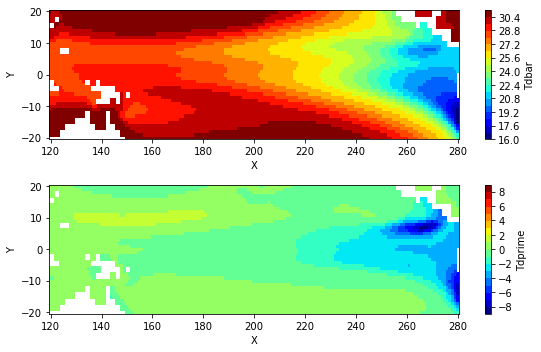

In [3]:
dt = xr.open_dataset('data/h20trend.nc').sel(Y=slice(-20,20),X=slice(120,280))

hp = ds.h20+dt.h20
hm = ds.h20
hOp = (pcoef[0]*hp + pcoef[1])*hp + pcoef[2]
hOm = (pcoef[0]*hm + pcoef[1])*hm + pcoef[2]

Tdp = splev(hOp, tck, der=0, ext=0)
Tdm = splev(hOm, tck, der=0, ext=0)

Tdprime = xr.DataArray(Tdp - Tdm,coords=[dt.Y, dt.X],dims=['Y','X'])
ds['Tdprime'] = Tdprime


plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
ds.Tdbar.plot(levels=21,cmap="jet")
plt.subplot(2,1,2)
ds.Tdprime.plot(levels=21,cmap="jet")
plt.tight_layout()

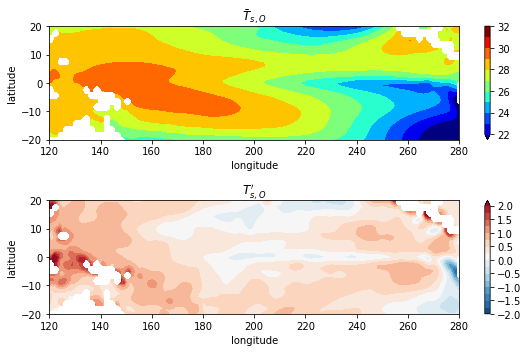

In [7]:
url = 'http://kage.ldeo.columbia.edu:81/expert/SOURCES/.LDEO/.ClimateGroup/.PROJECTS/.TCC/.ORAs4/.sst-clim.nc/.sst/dods'
dsst = xr.open_dataset(url).sel(Y=slice(-20,20),X=slice(120,280))
Tsbar = 1.0*dsst.sst
dsst['Tsbar'] = Tsbar + 0*Tdprime

urlt = 'http://kage.ldeo.columbia.edu:81/expert/SOURCES/.LDEO/.ClimateGroup/.PROJECTS/.TCC/.ORAs4/.sst-trend.nc/.sst/dods'
dsstt = xr.open_dataset(urlt).sel(Y=slice(-20,20),X=slice(120,280))
Tsprime = 1.0*dsstt.sst
dsstt['Tsprime'] = Tsprime+ 0*Tdprime

plt.figure(figsize=(8,5))

plt.subplot(211)
dp=dsst.Tsbar.plot.contourf(levels=11,cmap="jet",vmin=22,vmax=32,add_colorbar=0)
#,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r'$\bar T_{s,O}$')
plt.ylabel('latitude');plt.xlabel('longitude')
cbar = plt.colorbar(dp)
plt.subplot(212)
dp=dsstt.Tsprime.plot.contourf(levels=17,cmap="RdBu_r",vmin=-2,vmax=2,add_colorbar=0)
#,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r'$T_{s,O}^{\prime}$')
plt.ylabel('latitude');plt.xlabel('longitude')
cbar = plt.colorbar(dp)
plt.tight_layout()
plt.savefig('TsORA.eps', format='eps', dpi=1000)

/home/naomi/miniconda/envs/usual/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive
/home/naomi/miniconda/envs/usual/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


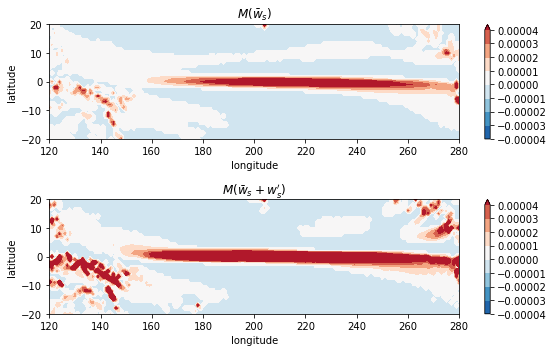

In [5]:
dwc = xr.open_dataset('data/uvws.nc')
dwt = xr.open_dataset('data/uvws-trend.nc')
Mwb = (dwc.ws+abs(dwc.ws))/2
Mwp = (dwc.ws+dwt.ws + abs(dwc.ws+dwt.ws))
#Tsprime = Tdprime - (Mwp - Mwb)*(Tsbar - Tdbar)/Mwp
Tsprime = Tdprime - (Mwp - Mwb)*(Tsbar - Tdbar)/Mwb

ds['Tsprime'] = Tsprime
ds['Mwb'] = Mwb
ds['Mwp'] = Mwp

plt.figure(figsize=(8,5))

plt.subplot(211)
dp=ds.Mwb.plot.contourf(levels=9,cmap="RdBu_r",vmin=-0.00004,vmax=0.00004,add_colorbar=0)
#,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r'$M(\bar w_s)$')
plt.ylabel('latitude');plt.xlabel('longitude')
cbar = plt.colorbar(dp)
#cbar.ax.set_ylabel(r'$T_d^{\prime}$', rotation=90) 

plt.subplot(212)
dp=ds.Mwp.plot.contourf(levels=9,cmap="RdBu_r",vmin=-0.00004,vmax=0.00004,add_colorbar=0)
#,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r'$M(\bar w_s+w^{\prime}_s)$')
plt.ylabel('latitude');plt.xlabel('longitude')
cbar = plt.colorbar(dp)
#cbar.ax.set_ylabel(r'$T_s^{\prime}$', rotation=90) 

plt.tight_layout()
plt.savefig('Mw.eps', format='eps', dpi=1000)

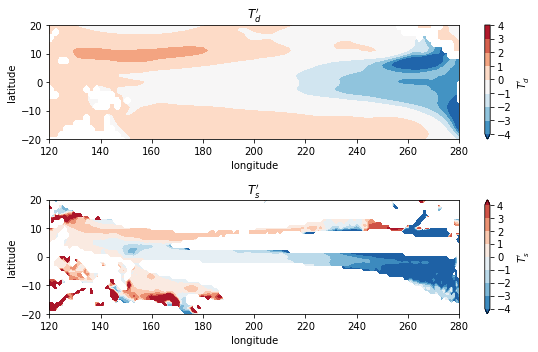

In [6]:
plt.figure(figsize=(8,5))

plt.subplot(211)
dp=ds.Tdprime.plot.contourf(levels=9,cmap="RdBu_r",vmin=-4,vmax=4,add_colorbar=0)
plt.title(r'$T_d^{\prime}$')
plt.ylabel('latitude');plt.xlabel('longitude')
cbar = plt.colorbar(dp)
cbar.ax.set_ylabel(r'$T_d^{\prime}$', rotation=90) 

plt.subplot(212)
dp=ds.Tsprime.plot.contourf(levels=9,cmap="RdBu_r",vmin=-4,vmax=4,add_colorbar=0)
plt.title(r'$T_s^{\prime}$')
plt.ylabel('latitude');plt.xlabel('longitude')
cbar = plt.colorbar(dp)
cbar.ax.set_ylabel(r'$T_s^{\prime}$', rotation=90) 

plt.tight_layout()
plt.savefig('Ts.eps', format='eps', dpi=1000)